<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/NBA_REB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 4.2 MB/s eta 0:00:00


#Domantas Sabonis

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301200   18    9    0   11    4   10    7     0     2    0    4    4   
1  0022301185   25    9    2   12    2   18    9     2     3    0    6    5   
2  0022301170   18    4    2   10    4   12    8     0     0    0    4    2   
3  0022301153    8    5    1   13    5    7    2     0     0    0    7    4   
4  0022301141   18    9    1   20    3   14    7     0     1    2    5    4   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          37           38       27       20       29          0  
1           7           46       34       21       37          2  
2         -16           32       22       14       28          2  
3         -18           26       13       18       21          1  
4          19           47       27       29       38          3  


<ipython-input-2-28ed1ddfbbb2>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  24.9651
RMSE: 4.9965
R^2:  -0.8390


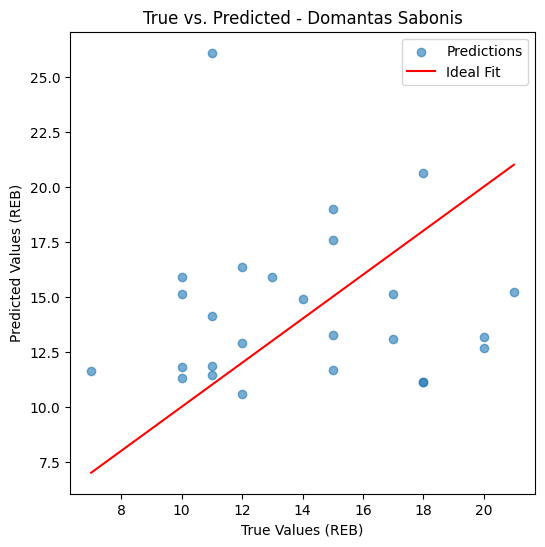


Using last 5-game averages for Domantas Sabonis:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  17.0  6.4  0.4  3.0  10.8  6.0   0.8   2.2  0.2  6.0  4.2        -3.4

Predicted REB for Domantas Sabonis: 12.93
The model predicts that Domantas Sabonis will go UNDER 14.5 in today's game.


In [2]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Anfernee Simons's player ID
Jugador_id = players.find_players_by_full_name("Domantas Sabonis")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Domantas Sabonis.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Domantas Sabonis')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 14.5  # Example threshold
print(f"\nUsing last 5-game averages for Domantas Sabonis:")
print(today_game_df)
print(f"\nPredicted REB for Domantas Sabonis: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Domantas Sabonis will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Domantas Sabonis will go UNDER {threshold} in today's game.")


#Alperen Sengun


Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022300929   14    2    2    6    0   14    7     0     0    0    2    0   
1  0022300916   19    6    1    9    1   15    7     0     0    1    8    5   
2  0022300897   23   14    2   19    3   19   10     0     0    0    8    3   
3  0022300891   45    3    5   16    2   32   19     2     3    1    7    5   
4  0022300870   21    2    2   10    3   21    9     0     2    1    4    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           5           22       16        8       20          2  
1           2           34       25       15       28          2  
2           2           56       37       33       42          2  
3          18           64       48       19       61          6  
4          16           33       23       12       31          3  

XGBRegressor Pe

<ipython-input-3-f904d920a6e4>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


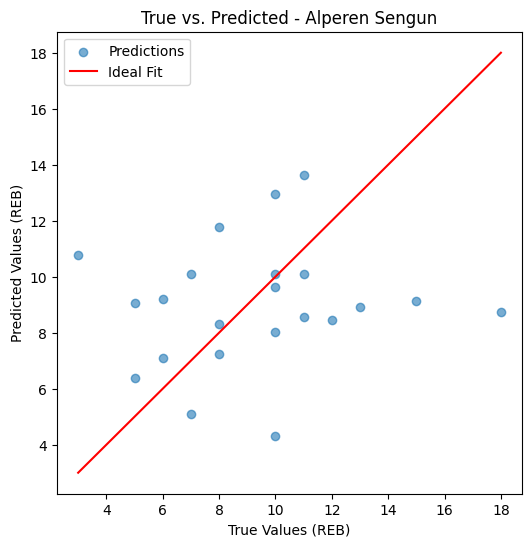


Using last 5-game averages for Alperen Sengun:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  19.4  4.4  0.6  1.8  14.0  7.0   0.2   1.0  0.2  8.2  5.2         4.4

Predicted REB for Alperen Sengun: 11.75
The model predicts that Alperen Sengun will go OVER 10.5 in today's game.


In [3]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Anfernee Simons's player ID
Jugador_id = players.find_players_by_full_name("Alperen Sengun")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Alperen Sengun.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Alperen Sengun')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 10.5  # Example threshold
print(f"\nUsing last 5-game averages for Alperen Sengun:")
print(today_game_df)
print(f"\nPredicted REB for Alperen Sengun: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Alperen Sengun will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Alperen Sengun will go UNDER {threshold} in today's game.")


#Amen Thompson

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301199   18   10    3   11    3    9    8     0     0    3    3    2   
1  0022301183   17    6    0   15    2   12    6     0     1    0    6    5   
2  0022301168   15    4    2   10    1   12    6     0     1    0    4    3   
3  0022301150   13    4    2    8    4    7    6     0     0    1    2    1   
4  0022301131    5    3    0    3    0    1    1     0     0    0    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          12           39       28       21       29          6  
1          15           38       23       21       32          0  
2          -1           29       19       14       25          2  
3           1           25       17       12       21          3  
4          17           11        8        6        8          0  


<ipython-input-4-a1f0896d4af4>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  9.5118
RMSE: 3.0841
R^2:  0.1174


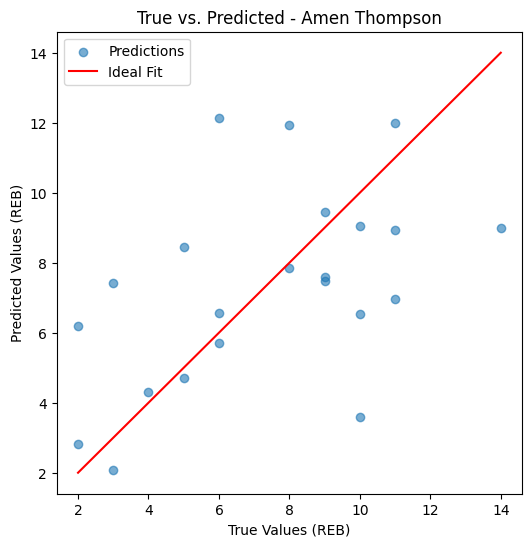


Using last 5-game averages for Amen Thompson:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  14.4  6.6  2.2  2.6  11.8  5.0   0.0   0.8  1.8  5.2  4.4        -0.8

Predicted REB for Amen Thompson: 9.54
The model predicts that Amen Thompson will go OVER 8.5 in today's game.


In [4]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Anfernee Simons's player ID
Jugador_id = players.find_players_by_full_name("Amen Thompson")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Amen Thompson.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Amen Thompson')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 8.5  # Example threshold
print(f"\nUsing last 5-game averages for Amen Thompson:")
print(today_game_df)
print(f"\nPredicted REB for Amen Thompson: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Amen Thompson will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Amen Thompson will go UNDER {threshold} in today's game.")


#Rudy Gobert

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   21    1    2    7    1    9    7     0     0    1    9    7   
1  0022301178   25    0    1   19    1   10   10     0     0    5    8    5   
2  0022301164   13    3    2   15    2    7    6     0     0    1    3    1   
3  0022301152   19    3    2   16    1    9    5     0     0    4   13    9   
4  0022301143   18    3    2   16    3   13    9     0     0    1    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -17           29       22        8       28          3  
1          13           44       25       19       44          6  
2         -17           31       16       18       28          3  
3          12           38       22       19       35          6  
4           8           37       21       19       34          3  


<ipython-input-7-c832ccd2c312>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  22.0181
RMSE: 4.6923
R^2:  -0.4456


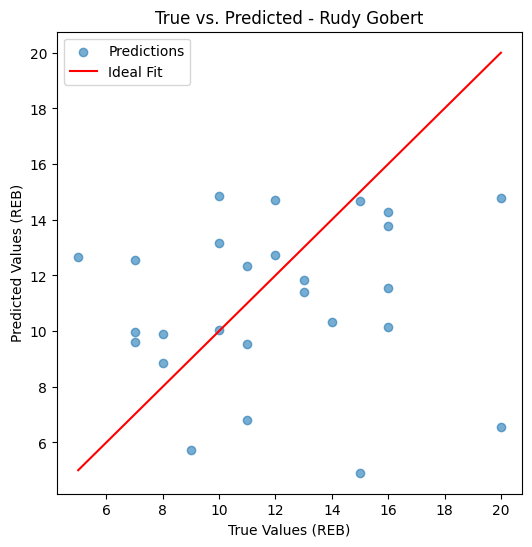


Using last 5-game averages for Rudy Gobert:
   HOME   PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  13.0  2.8  1.4  1.2  8.2  5.4   0.0   0.0  2.6  3.6  2.2         6.8

Predicted REB for Rudy Gobert: 15.18
The model predicts that Rudy Gobert will go OVER 10.5 in today's game.


In [7]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Rudy Gobert's player ID
Jugador_id = players.find_players_by_full_name("Rudy Gobert")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Rudy Gobert.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Rudy Gobert')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 10.5  # Example threshold
print(f"\nUsing last 5-game averages for Rudy Gobert:")
print(today_game_df)
print(f"\nPredicted REB for Rudy Gobert: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Rudy Gobert will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Rudy Gobert will go UNDER {threshold} in today's game.")


#Myles Turner

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301188   31    0    0   12    1   17   13     3     4    4    2    2   
1  0022301174   17    5    0    6    2   11    6     1     5    1    6    4   
2  0022301146   16    1    0    4    2   10    6     3     7    1    4    1   
3  0022301133   22    2    0   13    0   12    6     2     6    2    8    8   
4  0022301116   16    0    1    3    1   11    6     2     3    1    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          26           43       31       12       43          4  
1         -10           28       22       11       23          1  
2          14           21       17        5       20          1  
3          -4           37       24       15       35          2  
4          -2           19       16        3       19          2  


<ipython-input-9-944bf1a3b58f>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  6.8703
RMSE: 2.6211
R^2:  -0.0566


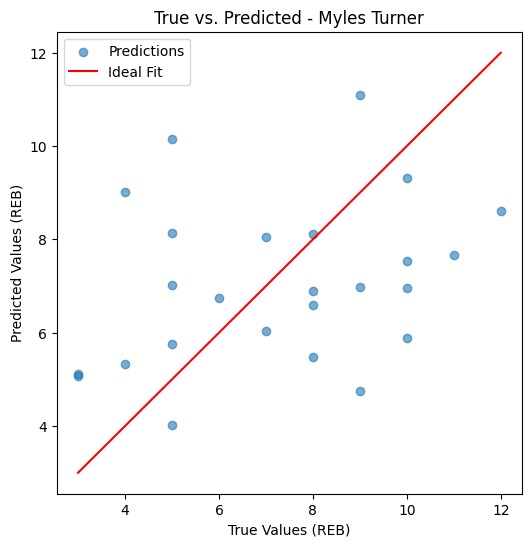


Using last 5-game averages for Myles Turner:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  15.2  1.8  0.8  1.8  11.8  4.6   2.4   6.2  0.6  4.4  3.6         0.0

Predicted REB for Myles Turner: 7.90
The model predicts that Myles Turner will go OVER 6.5 in today's game.


In [9]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Myles Turner's player ID
Jugador_id = players.find_players_by_full_name("Myles Turner")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Myles Turner.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Myles Turner')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 6.5  # Example threshold
print(f"\nUsing last 5-game averages for Myles Turner:")
print(today_game_df)
print(f"\nPredicted REB for Myles Turner: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Myles Turner will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Myles Turner will go UNDER {threshold} in today's game.")


#Ivica Zubac

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301184   10    0    0    2    0    6    5     0     0    1    0    0   
1  0022301156   17    2    0   13    3   13    8     0     0    2    1    1   
2  0022301132   14    1    0   11    3   10    7     0     0    0    0    0   
3  0022301126   12    2    1   10    0    6    5     0     0    3    2    2   
4  0022301114   14    1    1   15    0   11    4     0     0    0    6    6   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           8           12       10        2       12          1  
1          17           32       19       15       30          2  
2         -10           26       15       12       25          0  
3          15           24       14       12       22          4  
4          -5           30       15       16       29          1  


<ipython-input-11-522e3eea0444>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  13.9361
RMSE: 3.7331
R^2:  -0.2766


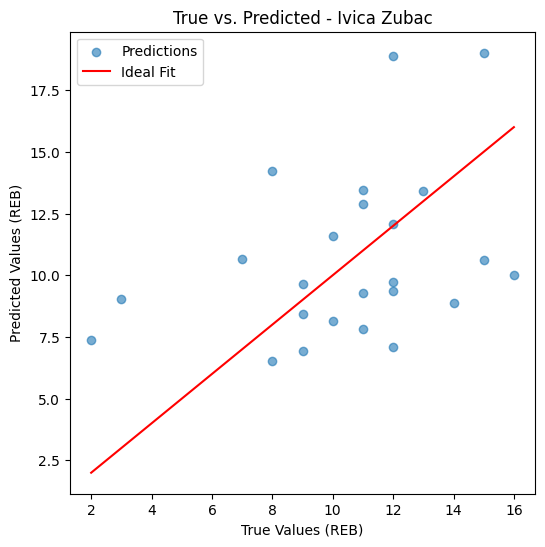


Using last 5-game averages for Ivica Zubac:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  17.2  2.4  1.0  1.4  12.2  7.2   0.0   0.0  0.8  2.8  2.8         7.4

Predicted REB for Ivica Zubac: 12.27
The model predicts that Ivica Zubac will go UNDER 12.5 in today's game.


In [11]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Myles Turner's player ID
Jugador_id = players.find_players_by_full_name("Ivica Zubac")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Ivica Zubac.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Ivica Zubac')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 12.5  # Example threshold
print(f"\nUsing last 5-game averages for Ivica Zubac:")
print(today_game_df)
print(f"\nPredicted REB for Ivica Zubac: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Ivica Zubac will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Ivica Zubac will go UNDER {threshold} in today's game.")


#LeBron James

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301195   28   17    5   11    4   20   11     0     2    1    6    6   
1  0022301177   37    5    2    9    8   20   13     3     7    0   11    8   
2  0022301155   33   11    2    7    4   22   14     1     3    0    5    4   
3  0022301127   24   12    1    5    5   18   10     1     5    1    5    3   
4  0022301103   25    9    3    7    4   18    9     0     1    0    9    7   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          19           56       45       28       39          6  
1          -3           51       42       14       46          2  
2          -6           51       44       18       40          2  
3          10           41       36       17       29          2  
4           9           41       34       16       32          3  

XGBRegressor Pe

<ipython-input-12-c0755437db02>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


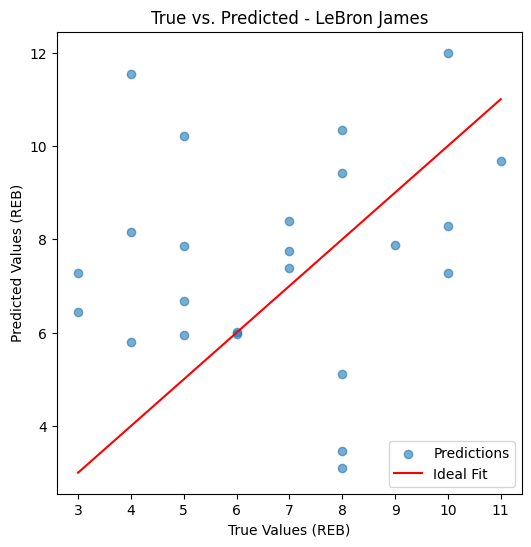


Using last 5-game averages for LeBron James:
   HOME   PTS  AST  STL  TOV   FGA   FGM  FG3M  FG3A  BLK  FTA  FTM  \
0     1  27.2  9.8  0.8  4.2  18.2  10.0   1.6   5.6  0.0  7.2  5.6   

   PLUS_MINUS  
0         9.8  

Predicted REB for LeBron James: 6.75
The model predicts that LeBron James will go UNDER 8.5 in today's game.


In [12]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Myles Turner's player ID
Jugador_id = players.find_players_by_full_name("LeBron James")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'LeBron James.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - LeBron James')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 8.5  # Example threshold
print(f"\nUsing last 5-game averages for LeBron James:")
print(today_game_df)
print(f"\nPredicted REB for LeBron James: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that LeBron James will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that LeBron James will go UNDER {threshold} in today's game.")
